<a href="https://colab.research.google.com/github/DKRakesh/Image-processing/blob/main/CNNGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install numpy pandas scikit-learn tensorflow keras deap

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from deap import base, creator, tools, algorithms
import random
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
results = []

In [ ]:
# Load the IMDB dataset
data = pd.read_excel('/content/SmallBook.xlsx')
X = data['review']
y = data['sentiment']

In [ ]:
# Tokenize the text data
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

# Convert 'sentiment' to binary labels
y = (y == 'positive').astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
def create_model(num_filters, kernel_size, pool_size, dense_layer_sizes, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=X.shape[1]))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size))
    model.add(Flatten())

    for layer_size in dense_layer_sizes:
        model.add(Dense(layer_size, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# Define the genetic algorithm fitness function
def evaluate_individual(individual):
    num_filters, kernel_size, pool_size, dense_layer_sizes, dropout_rate = individual
    dense_layer_sizes = init_dense_layer_sizes()  # Correctly obtain dense_layer_sizes

    model = create_model(num_filters, kernel_size, pool_size, dense_layer_sizes, dropout_rate)

    # Convert the input data to float32
    X_train_float32 = X_train.astype('float32')

    model.fit(X_train_float32, y_train, epochs=3, batch_size=128, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convert probabilities to binary predictions

    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1


In [ ]:
# Create a DEAP toolbox
creator.create('FitnessMax', base.Fitness, weights=(1.0, 1.0, 1.0, 1.0))
creator.create('Individual', list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

In [ ]:
# Define the hyperparameter search space
num_filters = [32, 64, 128]
kernel_size = [3, 5, 7]
pool_size = [2, 3]
dense_layer_sizes = [64, 128, 256]
dropout_rate = [0.3, 0.5]


# Define the custom initialization method for 'dense_layer_sizes'
def init_dense_layer_sizes():
    return [random.choice(dense_layer_sizes) for _ in range(3)]  # Choose the number of layers (3 in this case)

# Register the custom initialization method for 'dense_layer_sizes'
toolbox.register('dense_layer_sizes', init_dense_layer_sizes)

toolbox.register('num_filters', random.choice, num_filters)
toolbox.register('kernel_size', random.choice, kernel_size)
toolbox.register('pool_size', random.choice, pool_size)
toolbox.register('dense_layer_sizes', init_dense_layer_sizes)
toolbox.register('dropout_rate', random.choice, dropout_rate)
toolbox.register('individual', tools.initCycle, creator.Individual, (toolbox.num_filters, toolbox.kernel_size, toolbox.pool_size, toolbox.dense_layer_sizes, toolbox.dropout_rate), n=1)



In [ ]:
# Register the evaluate function in the toolbox
toolbox.register('evaluate', evaluate_individual)

# Create an initial population
population = [toolbox.individual() for _ in range(10)]

In [ ]:
# Define the genetic algorithm parameters
cx_prob = 0.7  # Crossover probability
mut_prob = 0.2  # Mutation probability
ngen = 5  # Number of generations
toolbox.register('mate', tools.cxTwoPoint)  # You can choose a crossover method (e.g., tools.cxOnePoint)
toolbox.register('mutate', tools.mutUniformInt, low=32, up=128, indpb=0.2)  # Define a mutation method

# Define the custom initialization method for 'dense_layer_sizes'
def init_dense_layer_sizes():
    return [random.choice(dense_layer_sizes) for _ in range(3)]  # Choose the number of layers (3 in this case)

# Register the custom initialization method for 'dense_layer_sizes'
toolbox.register('dense_layer_sizes', init_dense_layer_sizes)


In [ ]:
# Create an empty list to store results
results = []

In [ ]:
# Create empty lists to store metrics across generations
generation_numbers = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Create empty lists to store hyperparameters across generations
num_filters_values = []
kernel_size_values = []
pool_size_values = []
dense_layer_sizes_values = []
dropout_rate_values = []

In [ ]:
# Main genetic algorithm loop
for gen in range(ngen):
    offspring = algorithms.varAnd(population, toolbox, cxpb=cx_prob, mutpb=mut_prob)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

    # Select the next generation's population
    population[:] = tools.selBest(offspring, len(population))

    # Track and print the best individual and evaluation metrics for each generation
    best_individual = tools.selBest(population, k=1)[0]
    accuracy, precision, recall, f1 = evaluate_individual(best_individual)
    print("Generation {}: Best Accuracy = {:.2f}, Precision = {:.2f}, Recall = {:.2f}, F1 Score = {:.2f}".format(gen, accuracy, precision, recall, f1))

    # Append hyperparameter values to the lists
    num_filters_values.append(best_individual[0])
    kernel_size_values.append(best_individual[1])
    pool_size_values.append(best_individual[2])
    dense_layer_sizes_values.append(best_individual[3][0])
    dropout_rate_values.append(best_individual[4])

    # Append metrics to the lists
    generation_numbers.append(gen)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Append the results to the results list
    results.append([gen, accuracy, precision, recall, f1, best_individual])

    # Add early stopping condition if necessary (e.g., when accuracy plateaus)
    if len(results) > 1 and results[-1][1] == results[-2][1]:
        print("Early stopping: Accuracy plateaued.")
        break



4/4 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 3ms/step
Generation 0: Best Accuracy = 0.47, Precision = 0.45, Recall = 0.30, F1 Score = 0.36
4/4 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 0s 5ms/step
Generation 1: Best Accuracy = 0.50, Precision = 0.00, Recall = 0.00, F1 Score = 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: 'int' object is not subscriptable

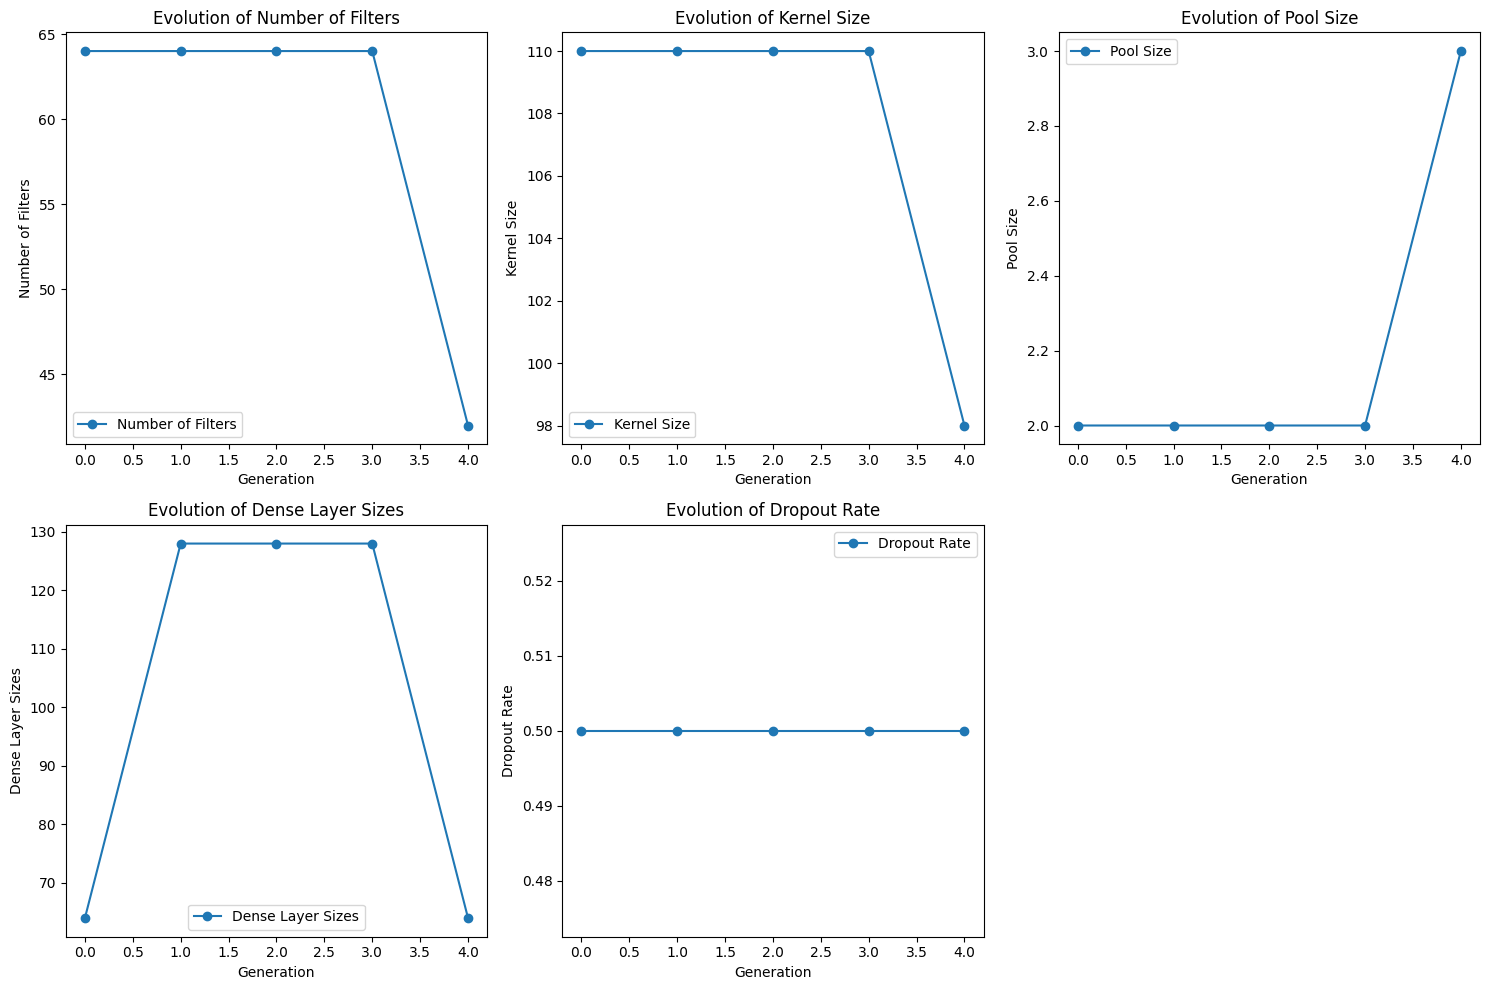

In [ ]:
# Plot line graphs for hyperparameters
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.plot(generation_numbers, num_filters_values, label='Number of Filters', marker='o')
plt.title('Evolution of Number of Filters')
plt.xlabel('Generation')
plt.ylabel('Number of Filters')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(generation_numbers, kernel_size_values, label='Kernel Size', marker='o')
plt.title('Evolution of Kernel Size')
plt.xlabel('Generation')
plt.ylabel('Kernel Size')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(generation_numbers, pool_size_values, label='Pool Size', marker='o')
plt.title('Evolution of Pool Size')
plt.xlabel('Generation')
plt.ylabel('Pool Size')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(generation_numbers, dense_layer_sizes_values, label='Dense Layer Sizes', marker='o')
plt.title('Evolution of Dense Layer Sizes')
plt.xlabel('Generation')
plt.ylabel('Dense Layer Sizes')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(generation_numbers, dropout_rate_values, label='Dropout Rate', marker='o')
plt.title('Evolution of Dropout Rate')
plt.xlabel('Generation')
plt.ylabel('Dropout Rate')
plt.legend()

plt.tight_layout()
plt.show()

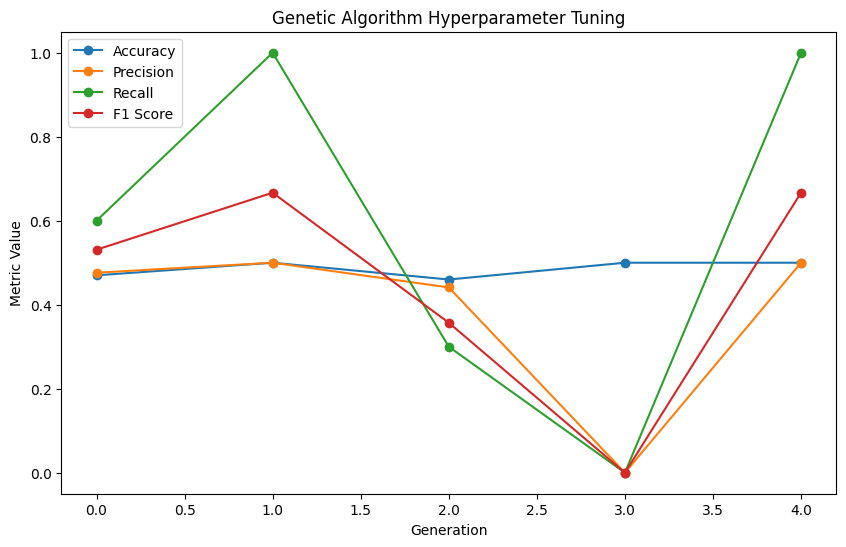

In [ ]:
# Plot line graphs for accuracy, precision, recall, and F1 score
plt.figure(figsize=(10, 6))
plt.plot(generation_numbers, accuracies, label='Accuracy', marker='o')
plt.plot(generation_numbers, precisions, label='Precision', marker='o')
plt.plot(generation_numbers, recalls, label='Recall', marker='o')
plt.plot(generation_numbers, f1_scores, label='F1 Score', marker='o')
plt.title('Genetic Algorithm Hyperparameter Tuning')
plt.xlabel('Generation')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
# Convert results to a NumPy array with dtype=object
results_array = np.array(results, dtype=object)

# Save results to a CSV file
np.savetxt('genetic_algorithm_results.csv', results_array, delimiter=',', fmt='%s', header='Generation,Accuracy,Hyperparameters')


In [ ]:
# Get the best individual and print its hyperparameters
best_individual = tools.selBest(population, k=1)[0]
best_accuracy = evaluate_individual(best_individual)[0]
print("Best Accuracy:", best_accuracy)
print("Best Hyperparameters:", best_individual)

4/4 [==============================] - 0s 5ms/step
Best Accuracy: 0.47999998927116394
Best Hyperparameters: [42, 98, 3, [64, 128, 256], 0.5]


In [ ]:
# Create and train the final model with the best hyperparameters
best_model = create_model(*best_individual)
best_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), verbose=2)


Epoch 1/10
4/4 - 3s - loss: 0.7027 - accuracy: 0.4461 - val_loss: 0.6934 - val_accuracy: 0.4800 - 3s/epoch - 706ms/step
Epoch 2/10
4/4 - 0s - loss: 0.6904 - accuracy: 0.5539 - val_loss: 0.6920 - val_accuracy: 0.5000 - 451ms/epoch - 113ms/step
Epoch 3/10
4/4 - 0s - loss: 0.6710 - accuracy: 0.6291 - val_loss: 0.6904 - val_accuracy: 0.5000 - 469ms/epoch - 117ms/step
Epoch 4/10
4/4 - 0s - loss: 0.6009 - accuracy: 0.6992 - val_loss: 0.7024 - val_accuracy: 0.5500 - 496ms/epoch - 124ms/step
Epoch 5/10
4/4 - 1s - loss: 0.4564 - accuracy: 0.8070 - val_loss: 0.6522 - val_accuracy: 0.5800 - 563ms/epoch - 141ms/step
Epoch 6/10
4/4 - 0s - loss: 0.2768 - accuracy: 0.8997 - val_loss: 0.8535 - val_accuracy: 0.5800 - 454ms/epoch - 113ms/step
Epoch 7/10
4/4 - 1s - loss: 0.1738 - accuracy: 0.9298 - val_loss: 1.2898 - val_accuracy: 0.5700 - 809ms/epoch - 202ms/step
Epoch 8/10
4/4 - 1s - loss: 0.1254 - accuracy: 0.9524 - val_loss: 1.3517 - val_accuracy: 0.5700 - 769ms/epoch - 192ms/step
Epoch 9/10
4/4 - 1s

In [ ]:
# Evaluate the final model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Final Model Test Accuracy:", test_accuracy)

4/4 [==============================] - 0s 5ms/step - loss: 1.1343 - accuracy: 0.6600
Final Model Test Accuracy: 0.6600000262260437
